# PDE Code Verification

Partial differential equations (PDEs) arise when solving governing differential equations in space and time and/or in multiple spatial dimensions. PDEs are more challenging to solve than ordinary differential equations (ODEs), in terms of both defining an appropriate numerical method and computational cost.

Code verification is defined in <a href="#ref-FDA2023">FDA, 2023</a> as the *“process of identifying errors in the numerical algorithms of a computer code"*. ASME V&V40 (<a href="#ref-VV40">ASME, 2018</a>) defines two credibility factors for code verification, software quality assurance (SQA) and numerical code verification (NCV). SQA involves ensuring *"that the software is functioning correctly and produces repeatable results on a specified computer resource in a specified software environment and is applicable to any computational model"*, and is applicable to any software product. NCV on the other hand only applies to differential equations-based computational models, and involves confirming that the numerical scheme for solving the differential equations has been implemented correctly. For example, by demonstrating the numerical solution converges to the true solution at the expected rates of convergence. For detailed introduction to NCV, see <a href="#ref-FDA2023">FDA, 2023</a>.

This notebook focuses on **the process of performing NCV for partial differential equation (PDE) based computational models**. The specific goals are: 
  1. Overview general approaches to NCV for PDE-based models, focusing in particular on the method of manufactured solutions (MMS)
  1. List test problems with exact solutions that can be used for performing NCV for computational models across a range of fields
  1. Demonstrate the process of performing NCV using the method of manufactured solutions, and discuss subtle considerations that arise
  1. Provide python code that can be used when analyzing and visualizing NCV results
  
# 1. Overview of NCV methods

To demonstrate that numerical solutions converge to the true solution of the governing equations at the expected rates of convergence, an exact solution of the mathematical problem is needed. In some cases, known analytic solutions are available. If not, exact solutions can be constructed using the method of manufactured solutions. These two approaches are discussed below.  

## 1.1. Analytic solutions

An analytic solution is an exact solution of the PDEs that has been obtained through direct mathematical analysis, typically for a specific choice of geometry, usually a simplified geometry such as a square, circle, cuboid or sphere, or one that is infinitely long in one or more of the dimensions, and perhaps also with simplying assumptions in terms of physics. For example, Fourier series based analytic solutions can be constructed for Laplace's equation using the separation of variables approach. Some other examples are provided in the Table below. 

However, for complex PDEs, especially nonlinear PDEs, analytic solutions may not be available, or if they are they may not exercise all terms in the governing equation. For example, a spatially linear analytic solution will not exercise spatial second derivative terms. The method of manufactured solutions, discussed next, provides an alternative method approach for generating exact solutions.  


## 1.2. Method of manufactured solutions

The method of manufactured solutions (MMS) involves choosing a solution *a priori*, inserting it into the governing equations, and calculating the corresponding source terms (i.e., PDE right hand side terms; also referred to as force terms) and boundary conditions that give rise to the chosen solution. Then, the PDE is solved using those source and boundary conditions to see if numerical solution matches the pre-selected solution. See <a href="#ref-Oberkampf2025">Oberkampf & Roy, 2025</a> for a detailed introduction. MMS is easiest illustrated using an example. Suppose Poisson's equation
\begin{equation}
\nabla^2 u = f(\mathbf{x})
\end{equation}
is to be solved on the unit cube for $u \equiv u(\mathbf{x})$, with boundary conditions 
\begin{align}
 u &= 0 \qquad \qquad &\textrm{ on $x=0$} \\
\boldsymbol{\nabla} u \cdot \mathbf{n} &= g(\mathbf{x}) \qquad &\textrm{ on $x=1,y=0,y=1,z=0$ or $z=1$}
\end{align}
where $\mathbf{n}$ is the outward facing unit normal. Choosing a solution $u = \sin(\pi x)\sin(2\pi y)\sin(3\pi z)$ (note that this satisfies the Dirichlet boundary conditon) and inserting into the above gives:
\begin{align}
f(\mathbf{x}) &= -14 \pi^2 \sin(\pi x)\sin(2\pi y)\sin(3\pi z) \\
\mathbf{g} &= \begin{cases}
-\pi \sin(2\pi y)\sin(3\pi z) &  \quad \textrm{on $x=1$} \\
2\pi \sin(\pi x)\sin(3\pi z) &  \quad \textrm{on $y=0$} \\
-2\pi \sin(\pi x)\sin(3\pi z) &  \quad \textrm{on $y=1$} \\
3\pi \sin(\pi x)\sin(2\pi y) &  \quad \textrm{on $z=0$} \\
-3\pi \sin(\pi x)\sin(2\pi y) &  \quad \textrm{on $z=1$} 
\end{cases}
\end{align}
NCV of a code solving Laplace's equation can be be performed by computing the solution on the unit cube using the above source terms and boundary conditions, and comparing with the pre-selected solution. 

The advantage of MMS is that exact solutions can be constructed in principle for any PDE, including nonlinear PDEs. The selected solution does not need to be physically realistic, since the goal of NCV is to confirm the equations are being solved correctly. One disadvantage of MMS is that the force terms or boundary conditions may not be compatible with the interface provided by a solver, for example a solver may assume a boundary condition value is constant or zero which would not allow for an MMS-derived boundary condition that a function of $\mathbf{x}$. A second disadvantage of MMS is that for complex PDEs, the number of terms in the computed force or boundary conditions can be large or even enormous (for an example see <a href="#ref-Aycock2020">Aycock, 2024</a>), even for a simple pre-selected solution. For such cases, it may be advisable or necessary to use a software symbolic computation package to calculate the MMS source and boundary conditions terms. 


# 2. Using the MMS


Below a workflow for MMS is provided. A prelimary step is to decide if new NCV is needed. This will depend on what NCV results are already available for the solver of interest. For example, for an estabished software package, relevant NCV results may already be publicly available. On the other hand, for a completely new software implementation of a computational model, implemented in medical device software, no previous public NCV results may be available. 

Also, a decision is required on the appropriate level of rigor in the NCV activities. As outlined in ASME V&V40 2018, this is dependent on the risk associated with using the model for the specified context of use. The below workflow corresponds to the highest level of rigor for the NCV credibility factor in ASME V&V40, that is, "*Discretization error was quantified by comparison to an exact solution, and a grid convergence study demonstrated that the numerical solution asymptotically approached the exact solution as the discretization was refined, and the observed order of accuracy was quantified and compared to the theoretical order of accuracy*" (<a href="#ref-VV40">ASME, 2018</a>)


## 2.1. Typical MMS workflow

The following is an example workflow for performing MMS for a given numerical solver. The sub-bullets consider cases that arise.
  1. If the solver accepts different geometries as input, choose a domain. This will typically be a regular geometry, e.g., unit cube.
  2. Choose an analytical solution for a field of interest in the governing equation. The solution does not need to be physically meaningful, but in general it needs be continuous and continuously differentiable, and ideally exercises all derivatives in the PDE including cross-derivatives. 
  3. Generate an analytical source term (i.e., a fictitious body force) and boundary conditions to satisfy the governing equations with the analytical solution
      * In some cases, it will be possible to do this by hand, i.e., on paper
      * For more complex equations, however, it may be advisable to perform this calculation using a symbolic computation package, for example using the `simpy` package; see <a href="#ref-Aycock2020">Aycock, 2020</a> for an example.
  5. Implement the source term and the appropriate boundary conditions
      * Ideally, the solver interface will be flexible enough to accept the computed source term and boundary conditions.
      * If not, for example if the body force is assumed in the solver to be a fixed gravitational force, the solver code might need internal modifications. In this case the MMS method becomes an intrusive method rather than a black-box test of the solver.   
  6. Select an appropriate error norm. The best norm is typically the norm for which the theoretical order of convergence is known.
      * For finite element solvers, the appropriate norm may require numerical integration over the geometry, e.g., an $L_2$ norm; see discussion below
      * For other solvers, see discussion below.
  7. Perform grid & time-step convergence studies by solving the governing equations with the specified source terms and boundary conditions using a range of grid resolutions $h$ and (if applicable) timesteps $dt$, and compute the error in the chosen error norm(s)
      * For static problems: ideally using at least three spatial resolutions and with a grid refinement ratio of around 2. If this is not possible, it is recommended in <a href="#ref-Oberkampf2025">Oberkampf & Roy, 2025</a> the refinement ratio be at least 1.3.
      * For dynamic problems: using any relevant conditions on $dt$ and $h$ such as the Courant-Friedrich-Levy (CFL) condition. 
  8. Quantify the observed order of convergence ($\textrm{OOC}_{\textrm{obs}}$) and compare with the theoretical ($\textrm{OOC}_{\textrm{theor}}$) convergence rates of the underlying numerical algorithm.
  
The remainder of this notebook primarily focuses on static problems. An end-to-end example of this workflow is provided in the Section 3 below.

<a id="exact_solns_table"></a>
## 2.2 Test problems with exact solutions

Exact solutions are available for a variety of modeling fields relevant to medical devices, either analytic solutions or constructed using MMS. The following table is a non-comprehensive list of exact solutions. These can be used for Steps 1-3 in the workflow above.



| Area     | Equations | Exact solution |  Source  |  
|:--------|:--------|:--------|:--------|
|Solid mechanics|Linear elasticity, nonlinear with Neo-Hookean, Hencky law |<a href="#ref-Aycock2020">Aycock, 2020</a>|MMS |	 
| Solid mechanics|Pseudoelasticity or superelasticity|<a href="#ref-Aycock2024">Aycock, 2024</a>|Analytic solutions|
|Fluid Dynamics	|Unsteady Tri-Periodic Vortex |<a href="#ref-Antuono2020">Antuono, 2020</a>| Analytic solutions|
|Fluid Dynamics|Circular Poiseuille Flow| <a href="#ref-Horner2021">Horner, 2021</a>|Method of Rotated Solutions|
|Fluid-Structure Interaction (FSI) |Steady FSI and 2D Unsteady FSI|	<a href="#ref-Etienne2012">Étienne, 2012</a>|MMS|
|Fluid Dynamics and Blood Damage|Planar Couette Flow and Circular Poiseuille Flow|<a href="#ref-Craven2019">Craven, 2019</a> (Sections 4.1.1 and 4.2.1)|Analytic Solutions|	 
|Electrophysiology|Monodomain, bidomain (with/without perfusing bath)| <a href="#ref-Pathmanathan2014">Pathmanathan, 2014</a> (Section 2.2)|MMS|
|Fluid Dynamics|Various|<a href="#ref-Masa">Malaya et al., 2013</a>|MMS (MMS solutions stored in a software library)|



## 2.3. Choosing an appropriate error norm

Since the goal of the workflow is to confirm the error converges to zero at the expected rate of convergence, the norm used to measure this error should based on error estimation theory for the numerical scheme used. 

### 2.3.1 Finite element method

Suppose the finite element method is used to solve the general elliptic problem defined above in Section 1.2, resulting in a numerical solution $u_h(x)$, a piecewise polynomial approximation to the true solution $u_{\textrm{true}}$ that is a polynomial of order $p$ in each finite element (e.g., $p=1$ corresponding to  linear elements), and where $h$ is a measure of mesh resolution (e.g., average edge length). Theoretical error convergence rates use the **square integral $L_2$ and Sobolev $H^1$ norms**, defined by:
\begin{align}
\| u \|_{L_2}^2 &= \int_{\Omega}u^2\,\mathrm{d}V  \\ %\intgl{\Omega}{u^2}{V} 
\| u \|_{H^1}^2 &= \int_{\Omega}u^2+|\boldsymbol{\nabla} u|^2\,\mathrm{d}V
\end{align}
Then, assuming certain conditions on the $\Omega$, $u_{\textrm{true}}$ and the finite element mesh (<a href="#ref-Ciarlet2002">Ciarlet, 2002</a>)
\begin{align}
e_{H^1} = \|u_h - u_{\textrm{true}}\|_{H^1} = \mathcal{O(h^p)} \qquad& \textrm{i.e., } \|u_h - u_{\textrm{true}}\|_{H^1} \le c_1 h^p \\
e_{L_2} = \|u_h - u_{\textrm{true}}\|_{L_2} = \mathcal{O(h^{p+1})} \qquad & \textrm{i.e., } \|u_h - u_{\textrm{true}}\|_{L_2} \le c_2 h^{p+1} 
\end{align}
for some $c_1>0$, $c_2>0$, and for sufficiently small $h$. For example, for when solving elliptic problems with linear finite elements, the theoretical order of convergence is $\mathcal{O(h^{2})}$ in the $L_2$ norm and $\mathcal{O(h)}$ in the $H^1$ norm. 

However, these quantities may not be practical or straightforward to compute, because they require integration over the domain. Often, a software package or library is used to solve the governing equations, and provides to the user the values $u_{h,i}$ at the nodes of the mesh. To compute the error in the $L_2$ or $H^1$ norms, the user may then need to implement numerical integration over the computational mesh themselves. 

An alternative error metric that is trivial to compute from the nodal solutions is the error in the **discrete $L_2$ norm**: 
\begin{equation}
e_{h,L_2} = h^{d/2}\|\mathbf{u}_h-\mathbf{u}_{\textrm{true}}\|_2 = h^{d/2}\left(\sum_{i} (u_{h,i} - u_{\textrm{true}}(\mathbf{x}_i))^2 \right)^{1/2}
\end{equation}
where $\|.\|_2$ is the standard vector $l_2$ norm, and $\mathbf{u}_h$ and $\mathbf{u}_\textrm{true}$ are vectors of nodal values of $u_h$ and $u_{\textrm{true}}$. $d$ is the spatial dimension and the scaling $h^{d/2}$ ensures $\mathcal{O(1)}$ functions have $\mathcal{O(1)}$ norms as $h\rightarrow 0$ (i.e., counteracts the sum over increasingly many values as $h$ decreases). This error metric is easy to compute, and approximates the $L_2$ error. However, it is important to note that rate of convergence rate of $e_{h,L_2}$ may not match the rate of convergence rate of $e_{L_2}$. In some cases, the theoretical order of convergence of the $e_{h,L_2}$ error may not be known. In others, such as some 1D problems, it may have been shown that the convergence of the $e_{h,L_2}$ error is faster than the convergence of the $e_{L_2}$ error (essentially, the solution converges faster at the nodes than inside the elements; so-called super-convergence (<a href="#ref-Schatz1996">Schatz et al., 1996</a>). For example, in the end-to-end worked example below, convergence in the discrete $L_2$ error will be $\mathcal{O(h^{4})}$ despite only using linear elements. Therefore, if the discrete $L_2$, or other discrete norm, is used as a surrogate to the integral $L_2$ norm, care is needed regarding claims of matching the theoretical order of convergence.



### 2.3.2 Error norms for other methods

Other commonly used methods of have different appropriate error norms. 
 * For the finite difference method, the solution is defined at a set of grid-points, and appropriate norms include the discrete $L_2$ norm as defined above or discrete $L_\infty$ norm $e_{h,L_\infty} = \textrm{max}\left(|u_{h,i} - u_{\textrm{true}}(\mathbf{x}_i)|\right)$. Typically, the error in these norms will be $\mathcal{O(h^p)}$ for some $p$, where $h$ is the spatial stepsize. For example, the central differences scheme for solving second order ODEs typically leads to $\mathcal{O(h^2)}$ convergence in the discrete $L_2$ or $L_\infty$ norms. 
 * For the finite volume method, rigorous theoretical error estimates - typically expressed in discrete analogues of $L_2$ or $H^1$ norms - are well established, and yield convergence rates comparable to those of the finite element method (<a href="#Eymard2000">Eymard, 2000</a>). 
 * A new method for solving differential equations using machine learning methods is physics-informed neural networks (PINNs). Unlike the traditional methods, theoretical convergence rates may not be available for PINNs. Code verification of PINN solvers are discussed in a separate Jupyter notebook in this toolbox.


## 2.4. Reasons for lower observed of convergence

If the observed order of convergence is less than the theoretical rate across the range of stepsizes, this could be due to, among others possibilities:
  * **The chosen spatial/temporal resolutions leading to errors that are converging but not yet in the asymptotic range. This can potentially be resolved by computing the error with smaller stepsizes**
  * An error in setting up or solving the MMS problem
  * An error in the simulation code
  * Other sources of errors, e.g., numerical errors related to the linear solver beginning to dominate the overall error
  * Issues related to round-off, for example printing the solution to file using insufficient precision, prior to loading into software that performs the convergence analysis.
  
  
# 3. End-to-end example

We will illustrate the overall process and discuss some of the nuances using a very simple 1D problem, $\frac{\mathrm{d}^2 u}{\mathrm{d}x^2} = f(x)$ on $[0,1]$ with boundary conditions $u=0$ on $x=0$ and $\frac{\mathrm{d} u}{\mathrm{d}x}=g$ on $x=1$. We use a simple 1D problem instead of a higher dimensional problem or a more interesting set of governing equations because it allows us to demonstrate all the points that we want to make about the MMS, while also being fast enough to solve numerically that all the below convergence analyses run near instantaneously on a laptop.

**Steps 1-3 - domain; manufactured solution; body force and boundary conditions:** Using the specified domain [0,1], we choose the solution $u(x) = \sin(2\pi x)$ which corresponds to $f(x) = -4 \pi^2 sin(2\pi x)$ and $g = 2\pi$. 

**Steps 4 - solve problem**: the function `solve_simple_prob` solves this problem, using the finite element method and linear elements. The finite element solver was implemented from scratch so that the impact of an intentional error can be investigated. The interface is `x, u = solve_simple_prob(force_term, boundary_condition, h, h)` where `force_term` is a function, `boundary_condition` is a scalar, and `h` is the spatial stepsize. Note that the interface allows any function of $x$ for the force term and any constant for the Neumann boundary condition. If the interface only allowed, say, a constant $f$ or zero $g$, the code would need intrusive editing to solve this MMS problem. The following code loads this function from the `src` folder. We also import two functions which compute integral-based norms (`error_in_L2_norm`, `error_in_H1_norm`).

In [1]:
import os
import sys
base_dir = os.getcwd() 
src_path = os.path.abspath(os.path.join(base_dir, '..', 'src'))
sys.path.insert(0, src_path)

from fe_solver_for_mms import solve_simple_prob, error_in_L2_norm, error_in_H1_norm

To solve the MMS problem we provide the MMS body force and boundary condition value. For illustration we first use a single value of $h$ and plot the numerical solution, true solution, and the error at the nodes.  

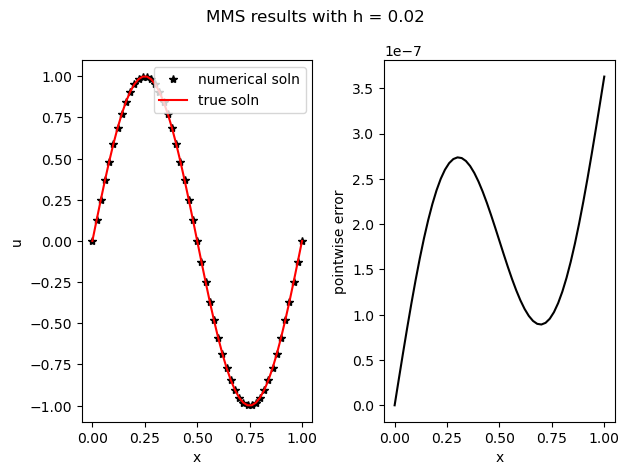

In [25]:
import math
from matplotlib import pyplot as plt
import numpy as np

def exact_soln(x):
    return np.sin(2*np.pi*x)

def exact_soln_derivative(x):
    return 2*np.pi*np.cos(2*np.pi*x)

def f(x):
    return -4*np.pi*np.pi*np.sin(2*np.pi*x)

bc = 2*np.pi
h = 0.02
x, u = solve_simple_prob(force_term=f,boundary_condition=bc,h=h)
u_true_at_nodes = exact_soln(x)

fig, ax = plt.subplots(1,2)
ax[0].plot(x,u,'k*',label="numerical soln")
ax[0].plot(x,u_true_at_nodes,'r',label="true soln")
ax[0].legend(loc='upper right')
ax[0].set_xlabel('x')
ax[0].set_ylabel('u')

ax[1].plot(x,u-u_true_at_nodes,'k-')
ax[1].set_xlabel('x')
ax[1].set_ylabel('pointwise error')

fig.suptitle('MMS results with h = 0.02')
fig.tight_layout()


<span style="display: none;">
$\newcommand{\intgl}[3]{\int_{#1}#2 \, \textrm{d}#3}$
$\newcommand{\bintgl}[4]{\int_{#1}^{#2} #3 \, \textrm{d}#4}$
</span>

**Step 5 - error norms**: Since the finite element method with linear elements was used to solve the governing equation, the theoretical order of convergence is $\mathcal{O}(h^2)$ in the $L_2$ norm, and $\mathcal{O}(h)$ in the Sobolev $H^1$ norm. We will compute errors in both of these norms. As discussed above, this requires numerical integration, which involved writing a function that loops over each element (within which $u_h$ is linear) and then using quadrature is estimate the required integrals. This is implemented in the functions `error_in_L2_norm` and `error_in_H1_norm`, imported earlier. We will also compute the discrete $L_2$ error as defined above.

In [26]:
error_L2 = error_in_L2_norm(x,u,exact_soln)
error_H1 = error_in_H1_norm(x,u,exact_soln,exact_soln_derivative)
error_discreteL2 = (h**(1/2))*np.linalg.norm(u-u_true_at_nodes)

print(f"Errors\nL2: {error_L2}, H1: {error_H1}, Discrete L2: {error_discreteL2}")


Errors
L2: 0.0009301345214251716, H1: 0.16113730330754172, Discrete L2: 2.00609470242655e-07


**Step 6 - convergence study**: Considering first just the $L_2$ norm, next we compute the solution using a range of meshes, a refinement ratio of 2, and plot the $L_2$ error as a function of $h$ on a log-log scale. The code below includes a helper function for plotting lines with slope equal to the theoretical rates. 

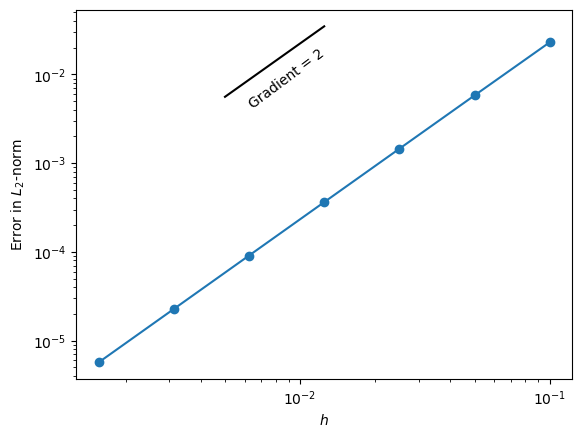

In [27]:
# initialize empty arrays
hs = np.array([0.1/2**n for n in range(0,7)])
errors_L2 = 0*hs
errors_H1 = 0*hs
errors_discreteL2 = 0*hs

# compute solution on a range of meshes and save the errors in different norms
for i, h in enumerate(hs):
    x, u = solve_simple_prob(force_term=f,boundary_condition=bc,h=h)
    u_true_at_nodes =  np.sin(2*np.pi*x)
    errors_L2[i] = error_in_L2_norm(x,u,exact_soln)  
    errors_H1[i] = error_in_H1_norm(x,u,exact_soln,exact_soln_derivative) # save for later plot
    errors_discreteL2[i] = (h**(1/2))*np.linalg.norm(u-u_true_at_nodes)   # save for later plot


# plot the L2 error against h
plt.loglog(hs,errors_L2,'-o')
plt.xlabel('$h$')
plt.ylabel('Error in $L_2$-norm')


def add_gradient_line(ax, grad): 
    """
    Draws a reference line of a specified log-log gradient on an existing
    Matplotlib Axes and annotates it with a correctly oriented label.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Target axis (should already be in log–log mode).
    grad : float
        Gradient (slope) of the reference line in log–log space
    """
        
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x1 = 10**(0.5*math.log10(xlim[0]) + 0.5*math.log10(xlim[1]))
    x2 = 10**(0.7*math.log10(xlim[0]) + 0.3*math.log10(xlim[1]))
    
    y1 = ylim[1]
    y2 = y1 * (x2/x1)**grad
    ax.plot([x1, x2], [y1, y2], 'k')
        
    # Calculate the angle of the line in degrees
    # Use log coordinates for proper angle calculation on log-log plots
    log_x1, log_y1 = math.log10(x1), math.log10(y1)
    log_x2, log_y2 = math.log10(x2), math.log10(y2)
    
    # Get the aspect ratio of the plot in log space
    x1_disp, y1_disp = ax.transData.transform((x1, y1))
    x2_disp, y2_disp = ax.transData.transform((x2, y2))
    angle = math.degrees(math.atan2(y2_disp - y1_disp, x2_disp - x1_disp))
    
    # Ensure text reads left-to-right (not upside down)
    if angle > 90:
        angle -= 180
    elif angle < -90:
        angle += 180
    
    # Position text at midpoint of line
    x_mid = 10**(0.5*math.log10(x1) + 0.5*math.log10(x2))
    y_mid = y1 * (x_mid/x1)**grad
    
    # Offset text perpendicular to the line
    offset_distance = -15.0  
    
    # Calculate perpendicular offset direction
    # For positive gradients, offset upward; for negative, offset downward
    if grad >= 0:
        offset_angle = angle + 90  # Perpendicular upward
    else:
        offset_angle = angle - 90  # Perpendicular downward
        
    # Convert offset to x,y components
    offset_x = offset_distance * math.cos(math.radians(offset_angle))
    offset_y = offset_distance * math.sin(math.radians(offset_angle))
    
    label = f"Gradient = {grad}"
    ax.annotate(label, 
               xy=(x_mid, y_mid), 
               xytext=(offset_x, offset_y),
               textcoords='offset points',
               rotation=angle,
               ha='center', 
               va='center',
               rotation_mode='anchor')

ax = plt.gca()
add_gradient_line(ax, 2)


**Step 7 - OOC**: The above plot includes a line with gradient equal to the theoretical order (in this case 2), and it appears the convergence has the same gradient, i.e.,  $\mathcal{O}(h^2)$ convergence as expected. This can be investigated more precisely by quantifying the actual rate of convergence:
\begin{equation}
p_{ij} = \frac{\ln(e_i/e_j)}{\ln(h_i/h_j)}
\end{equation}
The below code computes and plots this.

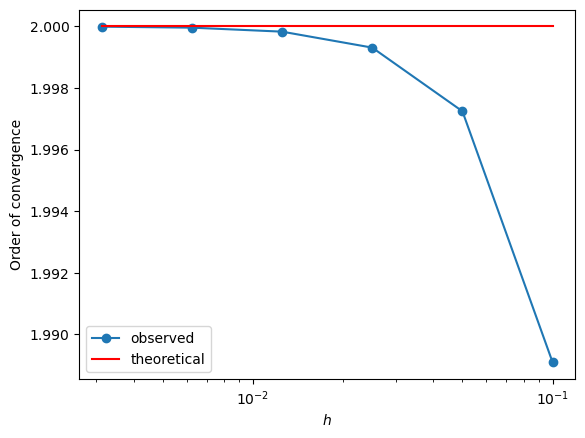

In [28]:
def calculate_OOC(coarse_res, fine_res, refinement_ratio):
    ooc = np.log(coarse_res / fine_res) / np.log(refinement_ratio)
    return ooc

def calculate_OOCs(errors, refinement_ratio):
    oocs = 0*errors[0:-1]
    for i in range(0,len(errors)-1):
        oocs[i] = calculate_OOC(errors[i], errors[i+1], refinement_ratio)
    return oocs

oocs_L2 = calculate_OOCs(errors_L2, refinement_ratio=2)

theoretical_rate = 2

plt.semilogx(hs[0:-1],oocs_L2,'-o',label='observed')
plt.xlabel('$h$')
plt.ylabel('Order of convergence')
plt.semilogx(hs[0:-1], theoretical_rate+0*hs[0:-1],'r', label='theoretical')
plt.legend(loc='best')

We see the observed order of convergence matches the expected theoretical order of convergence. 
 
Next, we repeat the last plots for the other two norms, the $H^1$ norm and discrete $L_2$ norm.

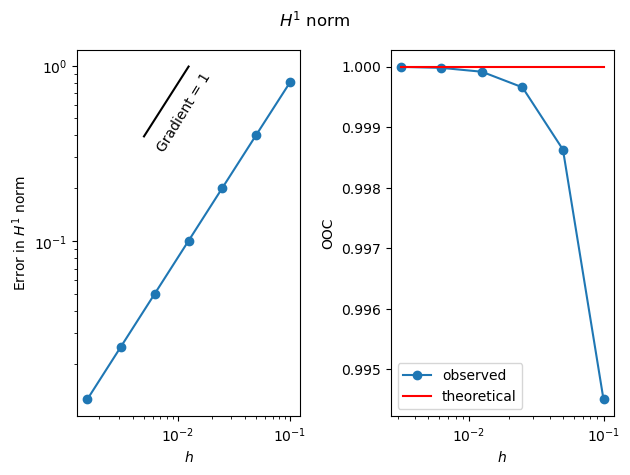

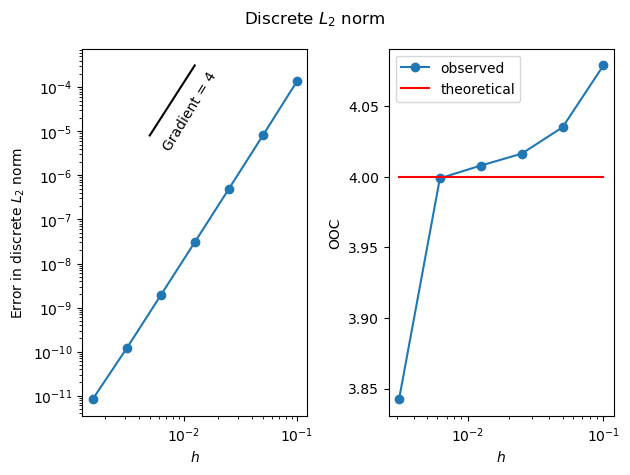

In [29]:
def plot_convergence_and_ooc(hs, errors, error_norm_name, title, theoretical = None):
    fig, ax = plt.subplots(1,2)
    ax[0].loglog(hs,errors,'-o')
    ax[0].set_xlabel('$h$')
    ax[0].set_ylabel(error_norm_name)

    add_gradient_line(ax[0],theoretical)
    
    ax[1].semilogx(hs[0:-1],calculate_OOCs(errors,2),'-o',label='observed')
    if theoretical is not None:
        ax[1].semilogx(hs[0:-1], theoretical+0*hs[0:-1],'r',label='theoretical')
    ax[1].set_xlabel('$h$')
    ax[1].set_ylabel('OOC')
    ax[1].legend(loc='best')
    
    fig.suptitle(title)
    fig.tight_layout()
    
plot_convergence_and_ooc(hs, errors_H1, 'Error in $H^1$ norm', "$H^1$ norm", theoretical=1 )
plot_convergence_and_ooc(hs, errors_discreteL2, 'Error in discrete $L_2$ norm', "Discrete $L_2$ norm", theoretical=4)

We see that the error in the $H^1$ norm is $O(h)$ as expected. The error in the discrete $L_2$ norm is actually $O(h^4)$ (at least until the high resolution mesh, when the error is very small ($\sim 10^{-11})$ and another source of error begins to dominate); much faster than in the $L_2$ norm. This is the superapproximation phenomena mentioned above. These results demonstrate how care is needed regarding claims of matching the theoretical order of convergence if a discrete norm is used as a surrogate to the norm the theory is based on. That is, if the observed convergence rate in the discrete $L_2$ norm had been $O(h^2)$, it would not necessarily follow that convergence in $L_2$ norm is also $O(h^2)$.

In the final part of this example, we demonstrate how the results change under two changes:
 1. Formulating the MMS problem incorrectly: a slightly incorrect boundary condition is passed in: $g= - 6.2831$, i.e., $2\pi$ rounded to four decimal places instead of $2\pi$ to machine precision. 
1. Introduction of a small error in the solver: a subtle error in which the Dirichlet boundary condition $u(0)=0$ is not properly implemented. To enforce the Dirichlet boundary condition, the linear system $K\mathbf{U}=\mathbf{F}$ that is constructed after looping over the elements, should be altered so that the first row of $K$ is $[1, 0, \ldots 0]$ and the first entry of $\mathbf{F}$ is zero. Calling `solve_simple_prob` with `intentional_error = True` introduces an intentional bug where the matrix $K$ is adjusted correctly but the right-hand side vector $\mathbf{F}$ is not.


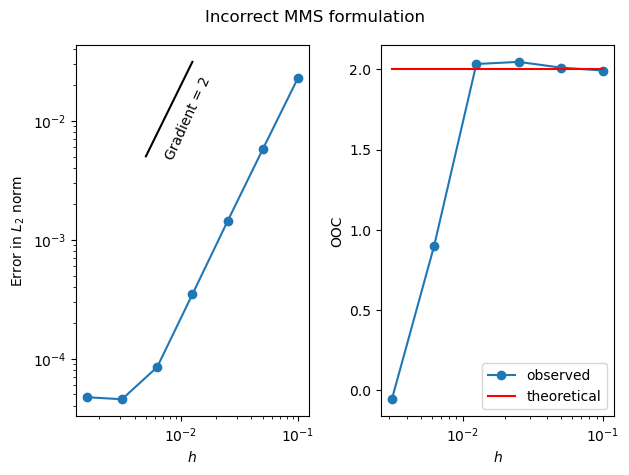

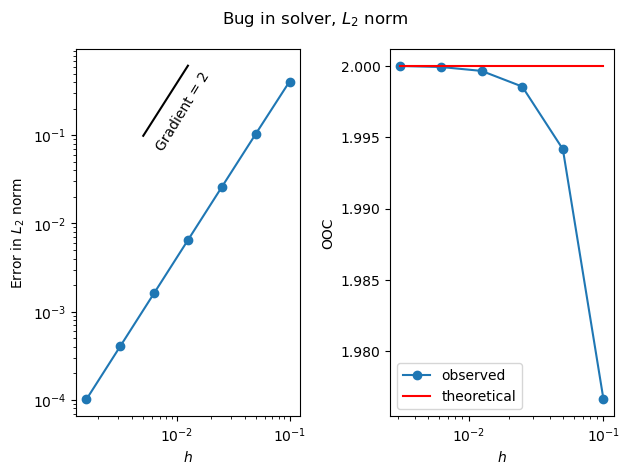

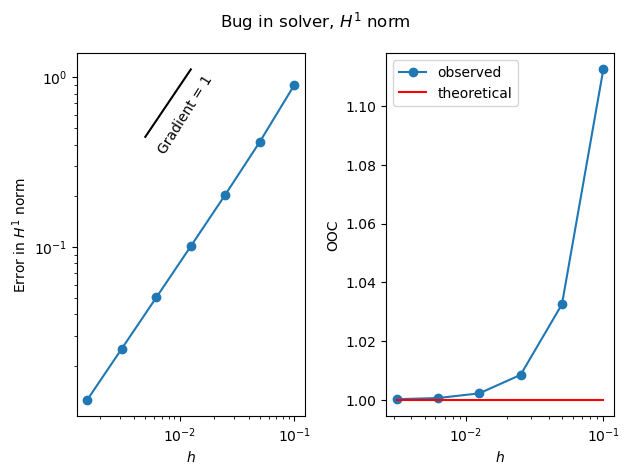

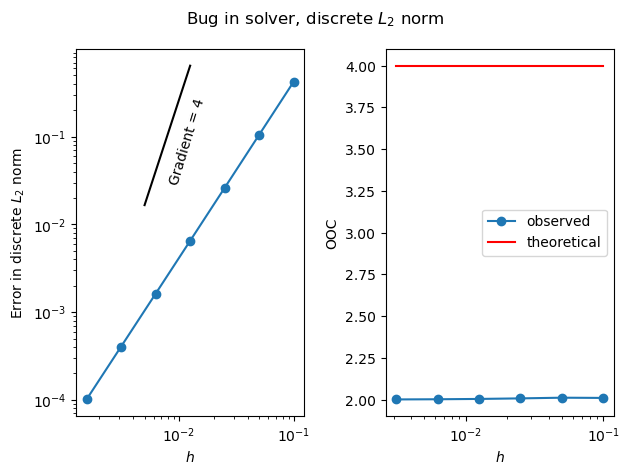

In [30]:
# set up arrays for storing the errors
errors_bad_mms = 0*hs
errors_L2_bug_in_solver = 0*hs
errors_H1_bug_in_solver = 0*hs
errors_discL2_bug_in_solver = 0*hs


for i, h in enumerate(hs):
    # Solve with bc=2*pi rounded to 4 decinal places instead of 2*pi to machine precision
    x, u = solve_simple_prob(force_term=f,boundary_condition=6.2831,h=h,intentional_error = False)
    u_true =  np.sin(2*np.pi*x)
    errors_bad_mms[i] = error_in_L2_norm(x,u,exact_soln)

    # Solve with intentional_error = True
    x, u = solve_simple_prob(force_term=f,boundary_condition=2*math.pi,h=h,intentional_error = True)
    u_true_at_nodes =  np.sin(2*np.pi*x)
    errors_L2_bug_in_solver[i] = error_in_L2_norm(x,u,exact_soln)
    errors_H1_bug_in_solver[i] = error_in_H1_norm(x,u,exact_soln,exact_soln_derivative)
    errors_discL2_bug_in_solver[i] = (h**(1/2))*np.linalg.norm(u-u_true_at_nodes)
    
    
plot_convergence_and_ooc(hs, errors_bad_mms,  'Error in $L_2$ norm', "Incorrect MMS formulation", theoretical=2)
plot_convergence_and_ooc(hs, errors_L2_bug_in_solver, 'Error in $L_2$ norm', "Bug in solver, $L_2$ norm", theoretical=2)
plot_convergence_and_ooc(hs, errors_H1_bug_in_solver, 'Error in $H^1$ norm', "Bug in solver, $H^1$ norm", theoretical=1)
plot_convergence_and_ooc(hs, errors_discL2_bug_in_solver, 'Error in discrete $L_2$ norm', "Bug in solver, discrete $L_2$ norm", theoretical=4)

For the incorrectly formulated MMS problem, initially the error converges at the expected rate but then stops converging, demonstrating the sensitivity of the MMS to small errors. 

For the intentional error in the boundary condition implementation, the error actually converges at the theoretical rate in the $L_2$ and $H_1$ norms, but the convergence rate in the discrete $L_2$ norm drops from $\mathcal{O}(h^4)$ to $\mathcal{O}(h^2)$.  


# References
<ul>
  <li id="ref-Antuono2020">M. Antuono, Tri-periodic Fully Three-Dimensional Analytic Solutions for the Navier–Stokes Equations, Journal of Fluid Mechanics, 2020.</li>
  <li id="ref-Aycock2020">K. Aycock et al., Method of Manufactured Solutions Code Verification of Elastostatic Solid Mechanics Problems in a Commercial Finite Element Solver, Computers & Structures, 2020.</li>
  <li id="ref-Aycock2024">K. Aycock et al., Method of Exact Solutions Code Verification of a Superelastic Constitutive Model in a Commercial Finite Element Solver, Advances in Engineering Software, 2024.</li>
  <li id=Ciarlet2002>P. Ciarlet, The Finite Element Method for Elliptic Problems, Classics in Applied Mathematics, 2002</li>
  <li id="ref-Craven2019">B. Craven et al., A CFD-Based Kriging Surrogate Modeling Approach for Predicting Device-Specific Hemolysis Power-Law Coefficients in Blood-Contacting Medical Devices, Biomechanics and Modeling in Mechanobiology, 2019.</li>
  <li id="ref-VV20">ASME, V&V20: Standard for Verification and Validation in Computational Fluid Dynamics and Heat Transfer, 2018.</li>
  <li id="ref-Etienne2012">S. Étienne el al., Some Manufactured Solutions for Verification of Fluid–Structure Interaction Codes, Computers & Structures, 2012.</li>
  <li id="ref-Eymard2000">R. Eymard et. al, Finite Volume Methods, in <i>Handbook of Numerical Analysis</i>, Vol. VII, 2000.
</li>  <li id="ref-FDA2023">FDA, Assessing the Credibility of Computational Modeling and Simulation in Medical Device Regulatory Submissions, 2023.</li>
  <li id="ref-Horner2021"> M. Horner, The Method of Rotated Solutions: A Highly Efficient Procedure for Code Verification, Journal of Verification, Validation and Uncertainty Quantification, 2021. </li>
  <li id="ref-MASA">Malaya et al., MASA: a library for verification using manufactured and analytical solutions, Engineering with Computers, 2013</li>
  <li id="ref-Oberkampf2025">W. Oberkampf and C. Roy, Verification and Validation in Scientific Computing, 2025.</li>
  <li id="ref-Pathmanathan2014"> P. Pathmanathan and R. Gray, Verification of Computational Models of Cardiac Electrophysiology, International Journal for Numerical Methods in Biomedical Engineering, 2014. </li>
  <li id="ref-Roache2009">P. Roache, Fundamentals of Verification and Validation, 2009.</li>
  <li id="ref-Schatz1996">A. Schatz et al., Superconvergence in Finite Element Methods and Meshes that are Locally Symmetric with Respect to a Point, 1996</li>
</ul>

